In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import neural

In [3]:
def bc_left_function(model, x, y, state):
    return torch.square(model(x)[0,:] - y)

def bc_left_setup(loss_block: neural.LossBlock, stats, epoch):
    if epoch is None:
        loss_block.x = torch.stack((torch.zeros(200), torch.linspace(0, 10, 200)), 0)
        loss_block.y = torch.zeros(200)
        loss_block.y[20:40] = 1
        loss_block.w = torch.ones(200)

        loss_block.state = loss_block.parameters["initial_state"]
    
bc_left_parameters= { "initial_state": {} }


def bc_right_function(model, x, _, state):
    output = model(x)
    return torch.square(output[0,:]/10000 - output[1,:])

def bc_right_setup(loss_block: neural.LossBlock, stats, epoch):
    if epoch is None:
        loss_block.x = torch.stack((torch.ones(200), torch.linspace(0, 10, 200)), 0)
        loss_block.y = None
        loss_block.w = torch.ones(200)

        loss_block.state = loss_block.parameters["initial_state"]
        
bc_right_parameters = {"initial_state": {}}



def ic_function(model, x, _, state):
    y_nn = model(x)
    return torch.sum(torch.square(y_nn), 0)

def ic_setup(loss_block: neural.LossBlock, stats, epoch):
    if epoch is None:
        loss_block.x = torch.stack((torch.linspace(0, 1, 200), torch.zeros(200)), 0)
        loss_block.y = None
        loss_block.w = torch.ones(200)
        
        loss_block.state = loss_block.parameters["initial_state"]

ic_parameters = {"initial_state": {}}


def physics_loss_function(model, x, _, state):
    y_nn = model(x)
    v = y_nn[0, :]
    i = y_nn[1, :]
    
    L = 3.0
    C = 3.0
    R = 0.01
    G = 1/10**5
    gamma = state["gamma"]

    grad_v = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    grad_i = torch.autograd.grad(i, x, grad_outputs=torch.ones_like(i), retain_graph=True, create_graph=True)[0]
    v_x = grad_v[0, :]
    v_t = grad_v[1, :]
    i_x = grad_i[0, :]
    i_t = grad_i[1, :]

    grad_v_x = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True)[0]
    grad_i_x = torch.autograd.grad(i_x, x, grad_outputs=torch.ones_like(i_x), retain_graph=True)[0]
    v_xx = grad_v_x[0,:]
    i_xx = grad_i_x[0,:]
    
    eq_1_error = v_x + L * i_t + R * i + gamma * i_xx
    eq_2_error = i_x + C * v_t + G * v + gamma * v_xx
    
    return 2*(torch.square(eq_1_error) + torch.square(eq_2_error))


def physics_setup(loss_block: neural.LossBlock, stats, epoch):
    if epoch is None:
        loss_block.x = torch.rand((2, 5000))
        loss_block.x[1, :] = 10 * loss_block.x[1, :]
        loss_block.x.requires_grad_(True)
        loss_block.y = None
        
        loss_block.state = loss_block.parameters["initial_state"]
    
    resample_period = loss_block.parameters["resample_period"]
    if resample_period is not None and resample_period != 0 and epoch % resample_period == 0:
        loss_block.x = torch.rand((2, 5000))
        loss_block.x[1, :] = 10 * loss_block.x[1, :]
        loss_block.x.requires_grad_(True)
        loss_block.y = None


physics_parameters = {
    "initial_state": {"gamma": 0.0},
    "resample_period": None
}

In [4]:
bc_left_loss_block = neural.LossBlock("bc_left", "bc_left_function", "bc_left_setup", bc_left_parameters)
bc_right_loss_block = neural.LossBlock("bc_right", "bc_right_function", "bc_right_setup", bc_right_parameters)
ic_loss_block = neural.LossBlock("ic", "ic_function", "ic_setup", ic_parameters)
physics_loss_block = neural.LossBlock("phys", "physics_loss_function", "physics_setup", physics_parameters)

model_config = neural.ModelConfig(
    [2, 5, 5, 5, 5, 2],
    "torch.tanh"
)

def update_training(trainer_config: neural.TrainerConfig, stats, epoch):
    if epoch is None:
        trainer_config.state.update(trainer_config.parameters["initial_state"])


trainer_config = neural.TrainerConfig(
    optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.001),
    lr_scheduler_config=None,
    update_function="update_training",
    parameters={"n_epochs": 50000, "initial_state": {}},
)

loss_blocks = [bc_left_loss_block, bc_right_loss_block, ic_loss_block, physics_loss_block]

function_dictionary = {
    "torch.optim.Adam": torch.optim.Adam,
    "torch.tanh": torch.tanh,
    "update_training": update_training,
    "bc_left_function": bc_left_function,
    "bc_left_setup": bc_left_setup,
    "bc_right_function": bc_right_function,
    "bc_right_setup": bc_right_setup,
    "ic_function": ic_function,
    "ic_setup": ic_setup,
    "physics_loss_function": physics_loss_function,
    "physics_setup": physics_setup,
}

complete_config = neural.CompleteConfig(model_config, trainer_config, loss_blocks, function_dictionary)

complete_config.save_json("the_config.json")

In [5]:
loaded_config = neural.CompleteConfig.load_json("the_config.json", function_dictionary)
final_model, stats = complete_config.train_model()

tensor(4.0404, grad_fn=<AddBackward0>)
tensor(0.0468, grad_fn=<AddBackward0>)
tensor(0.0418, grad_fn=<AddBackward0>)
tensor(0.0303, grad_fn=<AddBackward0>)
tensor(0.0259, grad_fn=<AddBackward0>)
tensor(0.0254, grad_fn=<AddBackward0>)
tensor(0.0251, grad_fn=<AddBackward0>)
tensor(0.0243, grad_fn=<AddBackward0>)
tensor(0.0225, grad_fn=<AddBackward0>)
tensor(0.0186, grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'Loss per category')

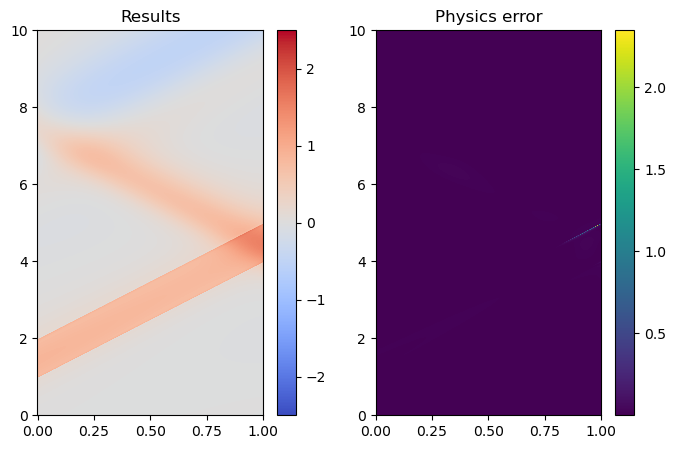

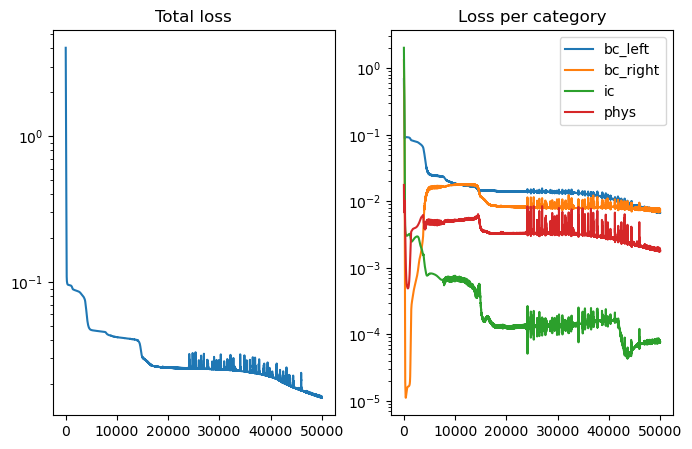

In [7]:
x_test = torch.linspace(0, 1, 2000)
t_test = torch.linspace(0, 10, 2000)

X, Y = torch.meshgrid(x_test, t_test)
in_test = torch.stack((X.reshape(-1), Y.reshape(-1)), 0)

with torch.no_grad():
    out = final_model(in_test)

fig = plt.figure(figsize=(8, 5))
axes = fig.subplots(1, 2)

img = axes[0].pcolormesh(
    X, Y, out[0,:].reshape(2000, 2000),
    cmap="coolwarm",
    vmin=-2.5,
    vmax=2.5
    )
# axes[0].scatter(residual_points[0,:].detach().numpy(), residual_points[1,:].detach().numpy(), s=1, c="g")
fig.colorbar(img)

in_test.requires_grad_(True)
phys_error = physics_loss_block.loss_function(final_model, in_test, None, physics_loss_block.state)

img = axes[1].pcolormesh(X, Y, phys_error.reshape(2000, 2000).detach().numpy())
fig.colorbar(img)

axes[0].set_title("Results")
axes[1].set_title("Physics error")


fig = plt.figure(figsize=(8, 5))
axes = fig.subplots(1, 2)
epochs = np.arange(complete_config.trainer_config.parameters["n_epochs"])
axes[0].semilogy(epochs, stats.total_loss_array)

labels = []
for name, loss in stats.individual_losses.items():
    axes[1].semilogy(epochs, loss)
    labels.append(name)
    
axes[1].legend(labels)

axes[0].set_title("Total loss")
axes[1].set_title("Loss per category")

In [27]:
import time
start = time.time_ns()
np.linalg.inv(np.random.uniform(-5, 5, (3900, 3900)))
print((time.time_ns() - start)/10**9)

0.952184325
